# Scattering covariance synthesis

In this notebook, we intend to do simple tests with scattering covariance synthesis:
* Gaussian field (ex: CMB) + synthesis with only P00 => Gaussian field and same Power Spectrum (PS)
* Non Gaussian field (ex: Venus) + synthesis with only P00 => Gaussian field and same PS
* Gaussian field + synthesis with all coeffs => Gaussian field and same PS
* Non Gaussian field + synthesis with all coeffs => Non Gaussian field and same PS


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from importlib import reload

import foscat.Synthesis as synthe
import foscat.scat_cov as sc
import almscat.Sphere_lib as sphlib

In [56]:
import tensorflow as tf
print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')))
print('Available devices:', tf.config.list_physical_devices())


Num GPUs Available: 1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Get data

In [104]:
# DEFINE A PATH FOR scratch data
# The data are stored using a default nside to minimize the needed storage
scratch_path = '../data'
nout = 256  # NSIDE

In [ ]:
##### TARGET MAP: Choose between a Gaussian or a non Gaussian field
#tmap = sphlib.make_hpx_sky(nside=nout, sky_type='cmb', normalize=True, nest=True)  # CMB
tmap = sphlib.make_hpx_planet(nside=nout, planet='moon', interp=True, normalize=True, nest=True,
                              dirmap='/obs/lmousset/projet/Spherical_wavelets/texture_maps')  # Venus

# Plot the healpix map
plt.figure(figsize=(10, 6))
hp.mollview(tmap, cmap='jet', nest=True, title='Target', min=-3, max=3)

# INITIALIZE FoCUS class

In [106]:
reload(sc)
scat_op = sc.funct(NORIENT=3,   # define the number of wavelet orientation
                   KERNELSZ=5,  # define the kernel size (here 5x5)
                   OSTEP=-1,     # get very large scale (nside=1)
                   LAMBDA=1.,
                   TEMPLATE_PATH=scratch_path,
                   slope=1.,
                   use_R_format=False,
                   all_type='float32')


          START FOSCAT CONFIGURATION
Num GPUs Available:  1
Physical devices cannot be modified after being initialized
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==


# Initialize the loss

In [107]:
# Write the loss function
def lossP00(x, scat_op, args):

    tP00 = args[0]
    norm = args[1]

    # Compute P00 on the iterating image
    xP00 = scat_op.eval(x, image2=None, norm=norm).P00

    loss = scat_op.reduce_sum(scat_op.square(xP00 - tP00))

    return loss

def lossAll(x, scat_op, args):

    tcoeff = args[0]
    norm = args[1]

    # Compute P00 on the iterating image
    xcoeff = scat_op.eval(x, image2=None, norm=norm)

    loss = scat_op.reduce_sum(scat_op.square(xcoeff - tcoeff))
    return loss

In [108]:
# Choose the normalisation
norm = 'auto'

# Compute the auto coeffs of the target image
scat_op.clean_norm()
tcoeff = scat_op.eval(tmap, image2=None, norm=norm)
tP00 = tcoeff.P00

# Choose the loss
loss = synthe.Loss(lossAll, scat_op, tcoeff, norm)
# loss = synthe.Loss(lossP00, scat_op, tP00, norm)

# Build the synthesis class
sy = synthe.Synthesis([loss])

# Run the synthesis

In [109]:
### Initial condition MAP
# Fix the seed
# np.random.seed(42)

# Make white gaussian noise
imap = np.random.randn(12*nout*nout)


In [85]:
### Run the synthesis
omap = sy.run(imap,
              DECAY_RATE=0.9998,
              NUM_EPOCHS = 2000,
              LEARNING_RATE = 0.03,
              EPSILON = 1E-16)

Total number of loss  1
Run on GPU CPU:0
Itt 0 L=1.11e+03 (1.11e+03 ) 70.845s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 3%]
Itt 100 L=45 (45 ) 106.728s 


/mesopsl3/home/lmousset/libs/FOSCAT/src/foscat/Synthesis.py:160: UserWarning: loadtxt: Empty input file: "smi_tmp.txt"
  return np.loadtxt('smi_tmp.txt')


Itt 200 L=20.7 (20.7 ) 107.286s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 0%]
Itt 300 L=13.6 (13.6 ) 107.852s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 5%]
Itt 400 L=9.89 (9.89 ) 108.196s 
Itt 500 L=7.67 (7.67 ) 108.566s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 0%]
Itt 600 L=6.21 (6.21 ) 108.342s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 0%]
Itt 700 L=5.22 (5.22 ) 108.552s 
Itt 800 L=4.55 (4.55 ) 108.180s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 3%]
Itt 900 L=4.07 (4.07 ) 108.514s 
Itt 1000 L=3.69 (3.69 ) 108.604s 
Itt 1100 L=3.39 (3.39 ) 108.499s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 0%]
Itt 1200 L=3.15 (3.15 ) 108.253s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 3%]
Itt 1300 L=2.94 (2.94 ) 108.791s 
Itt 1400 L=2.77 (2.77 ) 108.506s 
Itt 1500 L=2.62 (2.62 ) 108.548s 
Itt 1600 L=2.49 (2.49 ) 108.665s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 3%]
Itt 1700 L=2.37 (2.37 ) 108.497s 
Itt 1800 L=2.26 (2.26 ) 108.334s [GPU0 31461/32510 MB 0%][GPU1 0/32510 MB 3%]
Itt 1900 L=2.17 (2.17 ) 108.602s [

# Check the synthesis

In [86]:
# Compute the coeff
icoeff = scat_op.eval(imap, image2=None, norm=norm)
ocoeff = scat_op.eval(omap, image2=None, norm=norm)

tP00 = tcoeff.P00.numpy().squeeze()
iP00 = icoeff.P00.numpy().squeeze()
oP00 = ocoeff.P00.numpy().squeeze()

### Plot the maps

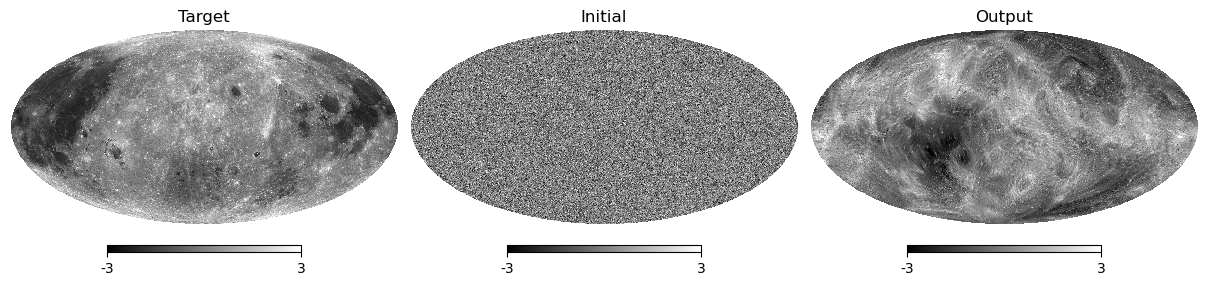

In [102]:
plt.figure(figsize=(12, 4))
hp.mollview(tmap, cmap='gray', hold=False, sub=(1, 3, 1), nest=True, title='Target', min=-3, max=3)
hp.mollview(imap, cmap='gray', hold=False, sub=(1, 3, 2), nest=True, title='Initial', min=-3, max=3)
hp.mollview(omap.numpy(), cmap='gray', hold=False, sub=(1, 3, 3), nest=True, title='Output', min=-3, max=3)

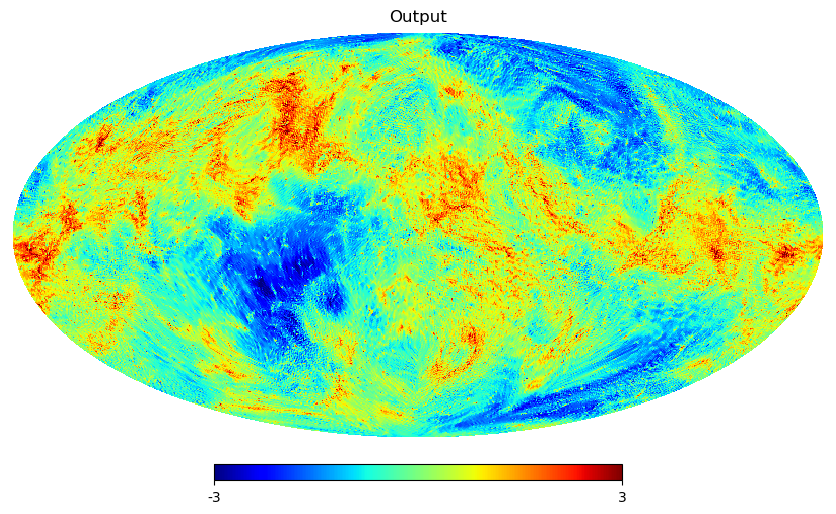

In [103]:
hp.mollview(omap.numpy(), cmap='jet', hold=False, nest=True, title='Output', min=-3, max=3)

### Plot all coeffs

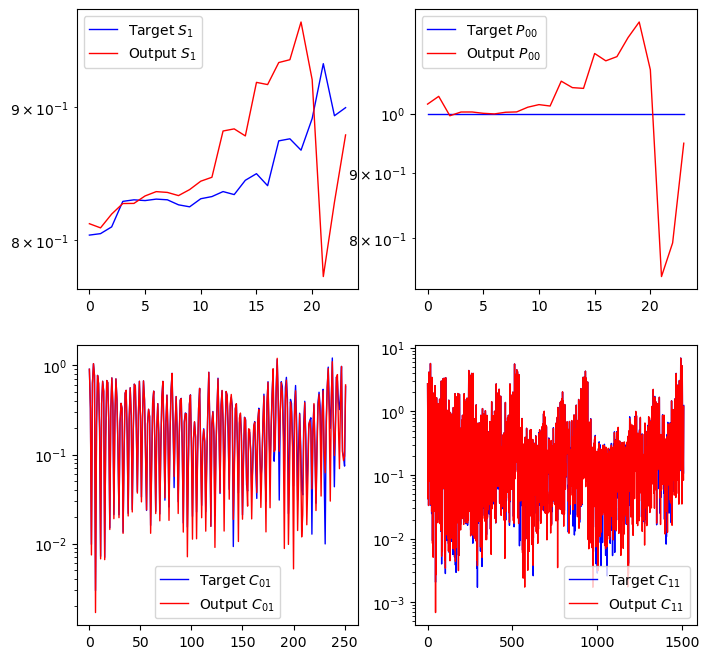

In [89]:
tcoeff.plot(color='b', name='Target')
# icoeff.plot(hold=False, color='g', name='Initial')
ocoeff.plot(hold=False, color='r', name='Output')


### Plot P00

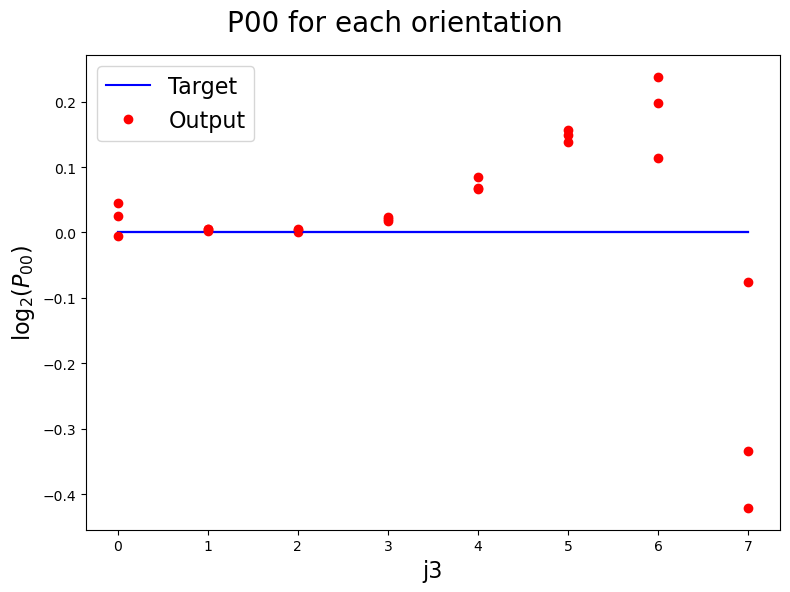

In [90]:
fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('P00 for each orientation',  fontsize=20)

for i in range(scat_op.NORIENT):
    ax0.plot(np.log2(tP00[:, i]), color='blue',label='Target')
    # ax0.plot(np.log2(gP00[:, i]), color='g',label='Initial')
    ax0.plot(np.log2(oP00[:, i]), 'o', color='red',label='Output')
    if i == 0:
        ax0.legend(fontsize=16)
ax0.set_xlabel('j3', fontsize=16)
ax0.set_ylabel(r'$\log_2(P_{00})$', fontsize=16)

fig.tight_layout()

### Angular power spectrum

Text(0, 0.5, '$C_\\ell$')

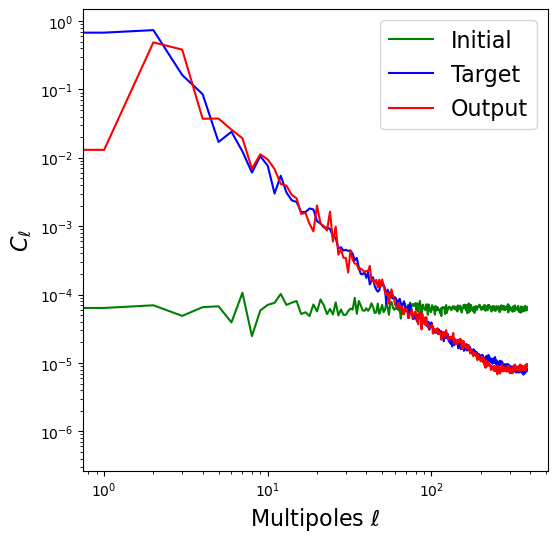

In [91]:
idx = hp.ring2nest(nout, np.arange(12*nout**2))

cli = hp.anafast((imap - np.median(imap))[idx])
clt = hp.anafast((tmap - np.median(tmap))[idx])
clo = hp.anafast((omap.numpy() - np.median(omap.numpy()))[idx])

plt.figure(figsize=(6,6))
plt.plot(cli,color='green',label=r'Initial')
plt.plot(clt,color='blue',label=r'Target')
plt.plot(clo,color='red',label=r'Output')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=16)
plt.xlabel(r'Multipoles $\ell$', fontsize=16)
plt.ylabel(r'$C_\ell$', fontsize=16)

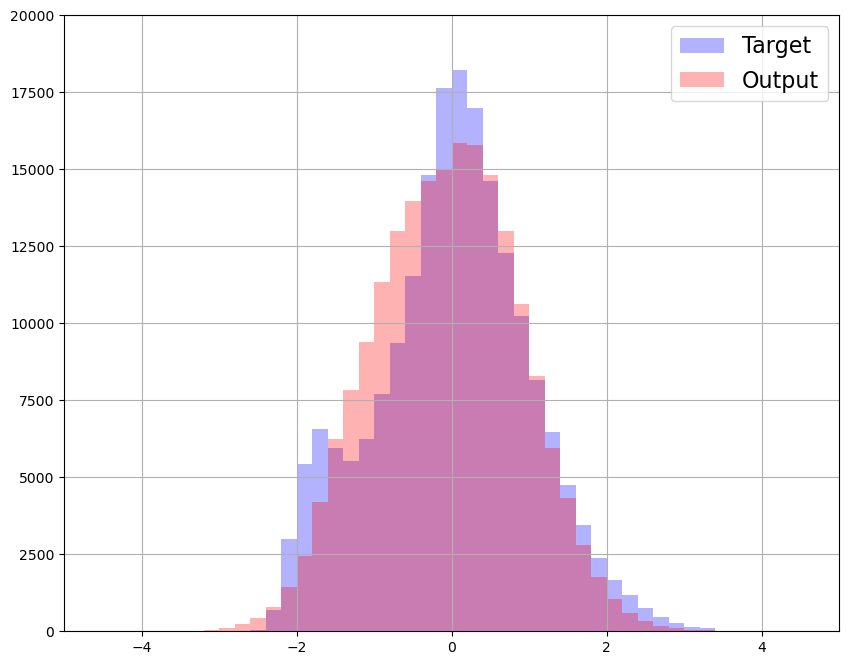

In [95]:
def plot_histo(target_hpx, synthetic_hpx, bins=50, range=(-5, 5), ymax=5000, fontsize=16):
    plt.figure(figsize=(10, 8))
    plt.hist(target_hpx.ravel(), bins=bins, range=range, color='b', alpha=0.3, label='Target')
    plt.hist(synthetic_hpx.ravel(), bins=bins, range=range, color='r', alpha=0.3, label='Output')
    plt.legend(fontsize=fontsize)
    plt.ylim(0, ymax)
    plt.xlim(range)
    plt.grid()
    return

plot_histo(tmap, omap.numpy(), ymax=20000)

(2000,)


Text(0.5, 0, 'Number of iterations')

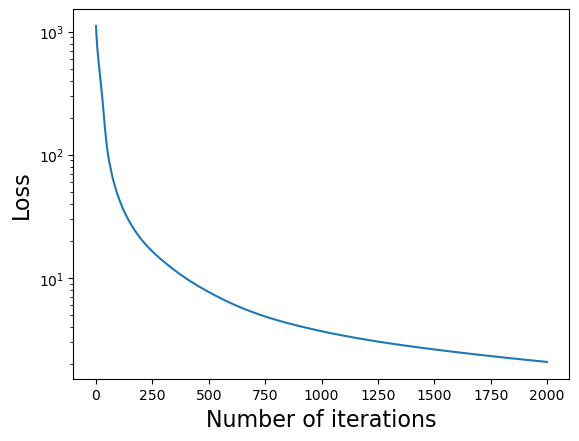

In [93]:
loss = sy.get_history()
print(loss.shape)


# Plot the loss
plt.figure()
plt.plot(loss[:])
plt.yscale('log')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)